# Polynomial Regression Prediction

In this notebook the amount of trips in an hour is predicted. The used algorithms are simple polynomial regression, ridge regression (L2) and lasso regression (L1). At the end, the best achieved performances are presented.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib import rcParams

In [3]:
full_data = pd.read_csv("load_prediction_data.csv", parse_dates=["start_time"])
full_data.head(1)

,start_time,trip_amount,start_hour,start_day,start_month,start_weekday,is_weekend,mean_duration_min,max_temp,precip
0,2017-01-01,4,0,1,1,6,1,9.5,-0.6,0.0


First we take our selected features and our target features out of the full dataset. Then the input features are scaled. After that we divide our input features into training, validation and test sets.

In [23]:
X_full = full_data[["start_hour","start_month","start_weekday","is_weekend","max_temp"]]
y_full = full_data["trip_amount"]

scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

# train-test split (30% test 49% train 21% validation)
X_temp, X_test, y_temp, y_test = train_test_split(X_full_scaled, y_full, test_size= 0.3, random_state= 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size= 0.3, random_state= 42)

def poly_features(X, d):
    poly_feat = PolynomialFeatures (degree = d)
    x_poly = poly_feat.fit_transform(X)
    return x_poly

def poly_regression(X, y, d):
    poly_reg = LinearRegression()
    poly_reg.fit(poly_features(X, d), y)
    return poly_reg

def evaluate(y_true, y_pred):
    print("MSE: " + str(mean_squared_error(y_true, y_pred)))
    print("MAE: " + str(mean_absolute_error(y_true, y_pred)))
    print("R^2: " + str(r2_score(y_true, y_pred)))


Lets test our polynomial prediction function.

In [24]:
# test poly prediction with degree = 8
model = poly_regression(X_train, y_train, 8)

y_model = model.predict(poly_features(X_valid, 8))

evaluate(y_valid, y_model)

MSE: 603.7918548714698
MAE: 17.19849599054002
R^2: 0.7544654153962529


For the hyperparameter selection we just iterate over possible hyperparameters and use the validation set to pick a value for the polynomial degree.

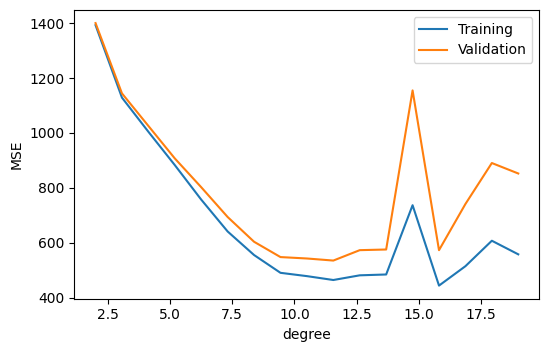

In [54]:
# simple polynomial prediction

# tune hyperparameter d
performance_train_set = list()
performance_valid_set = list()

min_degree = 2
max_degree = 18 # can take a long time for high numbers (5min for 18)
eval_function = mean_squared_error

for d in range(min_degree, max_degree + 1):
    model = poly_regression(X_train, y_train, d)
    
    y_model = model.predict(poly_features(X_train, d))
    performance_train_set.append(eval_function(y_train, y_model))

    y_model = model.predict(poly_features(X_valid, d))
    performance_valid_set.append(eval_function(y_valid, y_model))

rcParams['figure.figsize'] = 6, 3.75
plt.plot(np.linspace(min_degree, max_degree+1, max_degree + 1 - min_degree), performance_train_set)
plt.plot(np.linspace(min_degree, max_degree+1, max_degree + 1 - min_degree), performance_valid_set)

plt.legend(["Training", "Validation"])
plt.xlabel("degree")
plt.ylabel("MSE")
plt.show()

Next we introduce a regularization term. We start with ridge regression.

In [62]:
# ridge regression
def ridge_regression(X, y, d, alpha):
    model = Ridge(alpha=alpha)
    model.fit(poly_features(X, d), y)
    return model

# test ridge prediction with degree = 8
model = ridge_regression(X_train, y_train, 8, 1)

y_model = model.predict(poly_features(X_valid, 8))

evaluate(y_valid, y_model)

MSE: 609.1367861729661
MAE: 16.886523654928336
R^2: 0.7522918758291652


Now there are two hyperparameters to tune. Due to processing power limitations, we choose a high degree and iterate over possible alpha values to compare their performance on the validation set.

/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


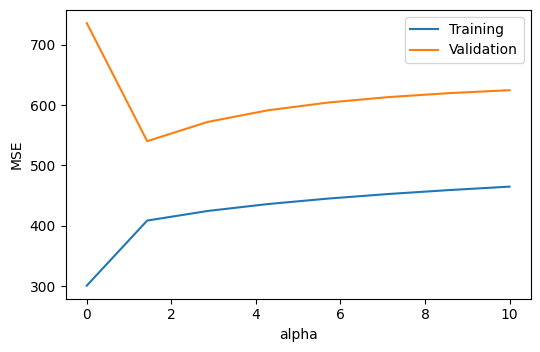

In [81]:
# ridge regression (L2) prediction

# tune hyperparameter a
performance_train_set = list()
performance_valid_set = list()

degree = 18 # increasing this will drastically increase runtime

min_alpha = 1e-6
max_alpha = 10
steps_alpha = 8 # increasing this will increase runtime
eval_function = mean_squared_error

for a in np.linspace(min_alpha, max_alpha, steps_alpha):
    model = ridge_regression(X_train, y_train, degree, a)
    
    y_model = model.predict(poly_features(X_train, degree))
    performance_train_set.append(eval_function(y_train, y_model))

    y_model = model.predict(poly_features(X_valid, degree))
    performance_valid_set.append(eval_function(y_valid, y_model))

rcParams['figure.figsize'] = 6, 3.75
plt.plot(np.linspace(min_alpha, max_alpha, steps_alpha), performance_train_set)
plt.plot(np.linspace(min_alpha, max_alpha, steps_alpha), performance_valid_set)

plt.legend(["Training", "Validation"])
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.show()

Next is Lasso regression. It uses a different regularization term compared to Ridge regression.

In [87]:
# lasso regression
def lasso_regression(X, y, d, alpha):
    model = Lasso(alpha=alpha)
    model.fit(poly_features(X, d), y)
    return model

# test lasso prediction with degree = 8
model = lasso_regression(X_train, y_train, 20, 10)

y_model = model.predict(poly_features(X_valid, 20))

evaluate(y_valid, y_model)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e+06, tolerance: 1.065e+03
  model = cd_fast.enet_coordinate_descent(


MSE: 1160.1572585511467
MAE: 22.603286527296085
R^2: 0.5282170035002938


/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e+06, tolerance: 1.065e+03
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+06, tolerance: 1.065e+03
  model = cd_fast.enet_coordinate_descent(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1

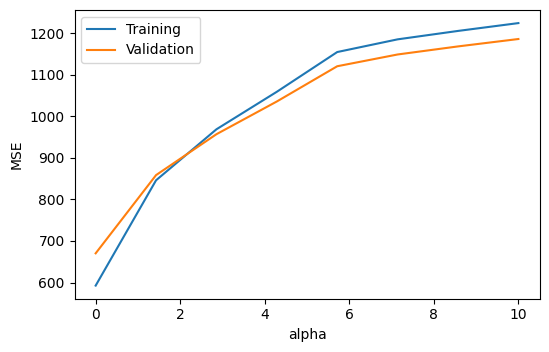

In [88]:
# lasso regression (L1) prediction

# tune hyperparameter a
performance_train_set = list()
performance_valid_set = list()

degree = 18 # increasing this will drastically increase runtime

min_alpha = 1e-6
max_alpha = 10
steps_alpha = 8 # increasing this will increase runtime
eval_function = mean_squared_error

for a in np.linspace(min_alpha, max_alpha, steps_alpha):
    model = lasso_regression(X_train, y_train, degree, a)
    
    y_model = model.predict(poly_features(X_train, degree))
    performance_train_set.append(eval_function(y_train, y_model))

    y_model = model.predict(poly_features(X_valid, degree))
    performance_valid_set.append(eval_function(y_valid, y_model))

rcParams['figure.figsize'] = 6, 3.75
plt.plot(np.linspace(min_alpha, max_alpha, steps_alpha), performance_train_set)
plt.plot(np.linspace(min_alpha, max_alpha, steps_alpha), performance_valid_set)

plt.legend(["Training", "Validation"])
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.show()

We can see that Lasso performs worse than ridge on our validation set.

Finally we use the results from our validation sets to benchmark our models on the test set with the chosen hyperparameters.

In [90]:
# best simple polynomial regression
print("Polynomial Regression")
degree = 9
model = poly_regression(X_train, y_train, degree)
evaluate(y_test, model.predict(poly_features(X_test, degree)))
# best ridge regression
print("Ridge Regression")
degree = 18
alpha = 1
model = ridge_regression(X_train, y_train, degree, alpha)
evaluate(y_test, model.predict(poly_features(X_test, degree)))
# best lasso regression
print("Lasso Regression")
degree = 18
alpha = 0.001
model = lasso_regression(X_train, y_train, degree, alpha)
evaluate(y_test, model.predict(poly_features(X_test, degree)))


Polynomial Regression
MSE: 584.255912982622
MAE: 16.28105878695432
R^2: 0.7792436134462717
Ridge Regression
MSE: 546.7892988581025
MAE: 14.952074626879462
R^2: 0.7934000715440741
Lasso Regression


/home/vscode/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+06, tolerance: 1.065e+03
  model = cd_fast.enet_coordinate_descent(


MSE: 716.6085787448399
MAE: 17.768125107588403
R^2: 0.7292352256915556
